In [1]:
%matplotlib inline

import os
import datetime
import time
import json

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.ensemble import ExtraTreesRegressor

In [2]:
## daily prices

def preprbd(x_db):
    x_db.columns = [x.lower() for x in x_db.columns.values]
    x_db.drop(['date_text','month','month day','day','year'],axis=1,inplace=True)
    x_db.drop(['open','high','low','market cap'],axis=1,inplace=True)


bit_price_d = pd.read_excel("bitcoin_data/btc_close_daily.xlsx")
preprbd(bit_price_d)
bit_price_d.rename(columns={'close':'btc_close'},inplace=True)

eth_price_d = pd.read_excel("bitcoin_data/eth_close_daily.xlsx")
preprbd(eth_price_d)
eth_price_d.rename(columns={'close':'eth_close'},inplace=True)

eth_price_d.head()

,date,eth_close,volume
0,2018-04-01,379.61,1256930000
1,2018-03-31,396.46,1323920000
2,2018-03-30,394.65,1878130000
3,2018-03-29,385.97,1970230000
4,2018-03-28,446.28,1514180000


In [3]:
## minute prices
##

bit_price = pd.read_csv('bitcoin_data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv')
bit_price.columns = [x.lower() for x in bit_price.columns.values]
bit_price['date_time'] = bit_price['timestamp'].map(lambda x: datetime.datetime.fromtimestamp(x)) ## MSC timezone
bit_price.head()

,timestamp,open,high,low,close,volume_(btc),volume_(currency),weighted_price,date_time
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:52:00
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:53:00
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:54:00
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:55:00
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39,2011-12-31 10:56:00


#### Graphs

Bitcoin price evalution 

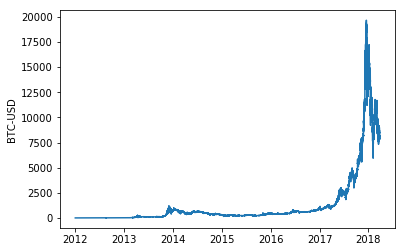

In [6]:
fig, ax = plt.subplots()
ax.plot(bit_price['date_time'],bit_price['open'])
ax.set_ylabel('BTC-USD')

plt.show()

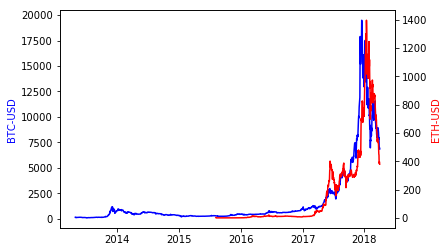

In [7]:
fig, ax1 = plt.subplots()

ax1.plot(bit_price_d['date'],bit_price_d['btc_close'],'b')
ax1.set_ylabel('BTC-USD',color='b')


ax2 = ax1.twinx()
ax2.plot(eth_price_d['date'],eth_price_d['eth_close'],'r')
ax2.set_ylabel('ETH-USD', color='r')
plt.show()

#### Reading news

In [159]:
re.sub("([0-9]*),([0-9]*)","\\1\\2","ninth in terms of BTC/USD ($1,536,570) trading")

'fdsf0234323432'

In [4]:
%%time

def clean_text(text):
    text = re.sub("<.*?>.*?</.*?>","",text)
    text = re.sub("&amp;","&",text)
    text = re.sub("\n"," ",text)
    text = re.sub("'","",text)
    text = re.sub("\$([0-9])","USD \\1",text)
    text = re.sub("([0-9])m","\\1 million",text)
    text = re.sub("([0-9])bn","\\1 billion",text)
    text = re.sub("([0-9]*),([0-9]*)","\\1\\2",text)
    text = re.sub("R&D","RnD",text)

    return text
    

## Loading text
DIR_FILE = "news_coindesk"
cd_news = []
for i_file in os.listdir(DIR_FILE):
    
    # read file
    tt = open (DIR_FILE + "/"+i_file)
    
    # process headline
    news_headline = tt.readline()
    news_headline = re.sub("\n","",news_headline)
    
    # now time for time
    news_time = tt.readline()
    news_time = datetime.datetime.strptime(news_time[0:10],"%Y-%m-%d")
    
    # news text and brief
    news_text = "".join(tt.readlines())
    try:
        news_brief = re.search("<brief>(.*?)</brief>",news_text).group(1)
    except:
        news_brief = ""
    news_text = clean_text(news_text)
    cd_news.append([news_time,news_headline,news_text])
    
    
print ("text loaded")

cd_news = pd.DataFrame(cd_news)
cd_news.columns = ['date','headline','text']

cd_news_full = cd_news.copy(deep=True)


## aggregate text and headlines on daily level
def compute_metrics(x):
    result = {'headline': " ".join(x['headline']), 'text': " ".join(x['text']),'count_news':len(x)}
    return pd.Series(result, name='metrics')

cd_news = cd_news.groupby('date').apply(compute_metrics)


cd_news.reset_index(inplace=True)
cd_news.sort_values('date',inplace=True)

## MAKE DATE SHIFT
## current news predict next date price
cd_news['date'] = [x + datetime.timedelta(days=1) for x in cd_news['date']]

print ("metrics computed")

cd_news.head()

text loaded
metrics computed
Wall time: 2min 10s


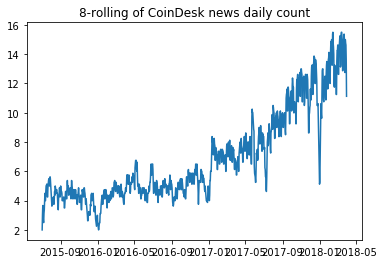

In [5]:
## Plot news count

fig, axs = plt.subplots()

aa = cd_news.rolling(8,min_periods=1)['count_news'].mean()
axs.plot(cd_news['date'],aa)
axs.title.set_text("8-rolling of CoinDesk news daily count")
plt.show()

In [6]:
##  Get daily spot price
##
all_data = bit_price_d[['date','btc_close']].copy(deep=True)
all_data.sort_values('date',ascending=True,inplace=True)
all_data.reset_index(inplace=True)
all_data.drop('index',axis=1,inplace=True)


## make returns
price = all_data['btc_close']
price_l1 = all_data['btc_close'].shift(1)
all_data['btc_return'] = (price - price_l1)/price_l1 * 100
all_data.dropna(inplace=True)


##  merge with news
all_data = all_data.merge(cd_news,how='left',on='date')
all_data.fillna('',inplace=True)


## make tfidf
tfidf = TfidfVectorizer(ngram_range=(1,1),min_df=5)
tfidif_vectors = tfidf.fit_transform(all_data['text'])
tfidf_col_names = tfidf.get_feature_names() ## list(tfidf.vocabulary_.keys())

tfidif_vectors


<1799x16503 sparse matrix of type '<class 'numpy.float64'>'
	with 1151537 stored elements in Compressed Sparse Row format>

In [7]:
## split into test and train
##

date_start = '2018-01-01'

filter_train = all_data['date'] < date_start
filter_test  = all_data['date'] >= date_start


matr = tfidif_vectors

dates_train =all_data.loc[filter_train,'date']
X_train = matr[np.where(filter_train)[0],]
y_train = all_data.loc[filter_train,'btc_return']

dates_test = all_data.loc[filter_test,'date']
X_test = matr[np.where(filter_test)[0],]
y_test =  all_data.loc[filter_test,'btc_return']

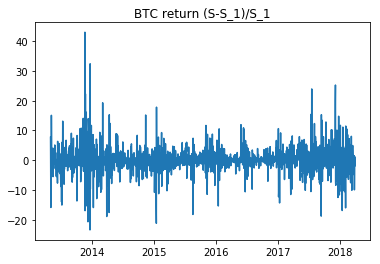

In [96]:
fig, ax = plt.subplots()
ax.plot(all_data['date'],all_data['btc_return'])
ax.set_title("BTC return (S-S_1)/S_1")

#### Ridge Model

In [200]:
def model_predict (mm,titles=["",""]):
    assert len(titles)==2
    
    y_pred = mm.predict(X_test)

    print (mean_squared_error(y_pred,y_test))
    print (r2_score(y_pred,y_test))


    y_pred = mm.predict(X_train)

    print (mean_squared_error(y_pred,y_train))
    print (r2_score(y_pred,y_train))

    ## Plot train data
    fig, (axs) = plt.subplots()
    axs.plot(dates_train,y_train,'b')
    axs.plot(dates_train,y_pred,'r')
    axs.set_title(titles[0])
    ## Plot test data
    y_pred = mm.predict(X_test)
    
    fig2, (axs2) = plt.subplots()
    axs2.plot(dates_test,y_test,'b')
    axs2.plot(dates_test,y_pred,'r')
    axs2.set_title(titles[1])

    fig2.autofmt_xdate()
    plt.show()

37.5362022086
-57.550076283
15.1745007643
-10.5980938827


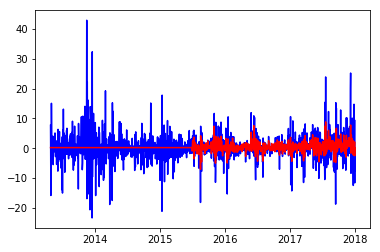

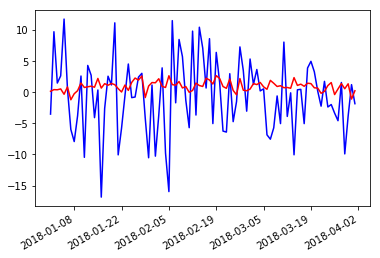

In [201]:
mm = Ridge(alpha=0.2, fit_intercept=True, normalize=False)
mm.fit(X_train,y_train)

model_predict(mm)

In [202]:
ind = np.argsort(np.abs(mm.coef_))
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, mm.coef_[i_ind])


plans -10.7315174466
axa -8.49638597191
whim 7.29816102877
white -7.24295634137
harder 7.21527911979
farms -7.1263621121
wayside -6.95051494199
technologically 6.90303587078
college 6.89468940262
coverage -6.77558513244
durability -6.65512630036
maksim -6.56440438356
automate -6.3971481275
brooklyn -6.37409663987
oleg -6.27741863952
good -6.2358149891
afterthought 6.21986539727
dealer 6.17720300913
savvy 6.14336791619
automobile 5.79579580612


37.5333362333
-57.5844237464


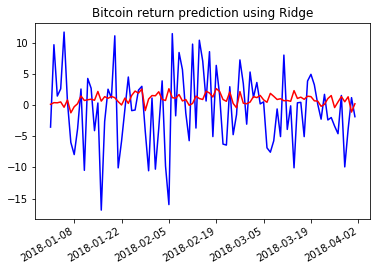

In [100]:
y_pred = mm.predict(X_test)

print (mean_squared_error(y_pred,y_test))
print (r2_score(y_pred,y_test))

fig,axs = plt.subplots()
axs.plot(dates_test,y_test,'b')
axs.plot(dates_test,y_pred,'r')
axs.set_title('Bitcoin return prediction using Ridge')
fig.autofmt_xdate()

plt.show()

#### Extra Trees

In [203]:
%%time
etr  = ExtraTreesRegressor(n_estimators=10, criterion='mse', max_depth=None, min_samples_split=2, min_samples_leaf=1, n_jobs = -1)
etr.fit(X_train,y_train)

Wall time: 24.7 s


47.0724323994
-3.27363754255
11.8915609813
-0.540505413448


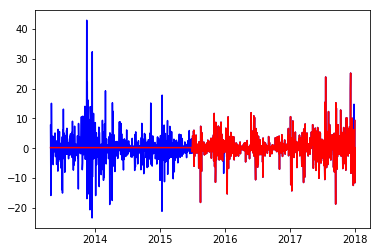

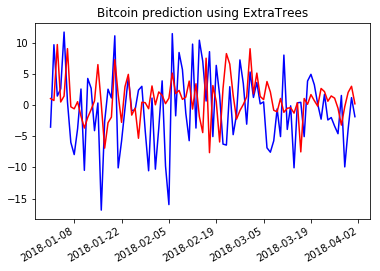

In [204]:
model_predict(etr,titles=["","Bitcoin prediction using ExtraTrees"])

In [205]:
imp = etr.feature_importances_
ind = np.argsort(imp)
ind = ind[::-1]

for i_ind in ind[0:20]:
    feat = tfidf_col_names[i_ind]
    print (feat, imp[i_ind])


commissions 0.0250986075129
34 0.0215583097529
college 0.0197268696942
research 0.0180043523075
mislead 0.0140904212219
1050 0.0126741879173
repression 0.0121110513412
75 0.0120681728952
amazed 0.0112001038837
putting 0.0107866958964
dah 0.0104812155035
colorful 0.0102093318438
ideological 0.0099728256482
needing 0.00997194280687
cyberspace 0.00972380680246
paxos 0.00949441117455
lempres 0.00939325343612
80000 0.00857507681371
revolutionary 0.00856235132444
regret 0.00844634281964


In [87]:
## search for text
##

for i_hh in all_data['text']:
    aa = re.search('012',i_hh,re.IGNORECASE)
    if aa is not None:
        print (i_hh,"\n")

  Can bitcoin conquer Argentina? It's a question that is being given increasing validity by major media outlets like The New York Times and The Economist, and it's easy to see why. Numerical and anecdotal evidence suggest that if bitcoin will prove popular as a currency anywhere, it should in Argentina. According to the Bitcoin Market Potential Index (BMPI), which ranks bitcoin's potential utility across 177 countries, Argentina is the most likely country to adopt the digital currency. It's economy is one of the most problematic globally, boasting annual inflation of approximately 35%. In theory, this means monetary stability in Argentina is particularly weak. In practice, it has led to a thriving black market for alternative means of exchange. Small, fervent user base The prominence of bitcoin in Argentina isn't in dispute, with interviewees telling CoinDesk its adoption is comparable to that seen in New York or San Francisco. Tech entrepreneur Joan Cwaik, for example, estimates Argen

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [108]:
i_col = np.where([x == '512' for x in tfidf_col_names])[0]
i_col = i_col[0]

print (tfidf_col_names[i_col])
aa = pd.DataFrame(tfidif_vectors[:,i_col].todense())
aa.columns = ["word"]
aa = aa.query("word>0")
print (aa)

512
          word
996   0.010503
1692  0.005265
1710  0.006876
1713  0.006550
1754  0.005761
1760  0.004892
1761  0.005500
1767  0.009441


In [206]:
all_data.loc[1761,'text']

'  Signs of bull market exhaustion in the bitcoin market may be having a knock-on effect across cryptocurrencies in general. All of the top 100 cryptocurrencies by market capitalization - bar nano dentacoin and tether - are in the red today according to CoinMarketCap data. Bitcoin (BTC) has dropped over 8 percent in the last 24 hours as was indicated by the bearish reversal pattern on the daily charts and head-and-shoulders breakdown on the hourly chart. As of writing BTC had dropped to USD 9958 - down 16.72 percent from the recent high of USD 11958 hit on Feb. 20. if("undefined"==typeof window.datawrapper)window.datawrapper={};window.datawrapper["4LVL8"]={}window.datawrapper["4LVL8"].embedDeltas={"100":512.0208339999999"200":485.020834"300":459.020834"400":459.020834"500":459.020834"700":459.020834"800":459.020834"900":459.020834"1000":459.020834}window.datawrapper["4LVL8"].iframe=document.getElementById("datawrapper-chart-4LVL8")window.datawrapper["4LVL8"].iframe.style.height=window.

#### LDA


In [8]:
### https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
##

from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim

tokenizer = RegexpTokenizer(r'\w+')

# create English stop words list
en_stop = get_stop_words('en')

# Create p_stemmer of class PorterStemmer
p_stemmer = PorterStemmer()


C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [9]:
%%time

texts = []
# loop through document list
for i in cd_news_full['text']:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop]
    
    # stem tokens
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    # add tokens to list
    texts.append(stemmed_tokens)
print ("done steming, tokenization and etc")
    
# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
print ("Now I have dictionary")

# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
print ("Corpus initialization done")

# generate LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=20)
lda.save('nlp/lda')
print ("Finished lda model")

done steming, tokenization and etc
Now I have dictionary
Corpus initialization done


NameError: name 'lda' is not defined

In [ ]:
for i_text in texts:
    if 's' in i_text:
        print (texts)
        assert 1=2

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [152]:
lda[corpus[4]]

[(7, 0.093762964), (15, 0.9013983)]